### RNN

#### Seq2Seq 기계 번역


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [5]:
model = Seq2Seq(vocab_size, 16)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
log = []
for i in range(1000):
    prediction = model(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print(f"\n 반복:{i} 오차: {loss_val.item()}")
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.525089740753174
['-', '\x13', 'S', 'S']

 반복:100 오차: 1.9251470565795898
['h', 'o', 'h', 'a']

 반복:200 오차: 0.7702123522758484
['h', 'o', 'l', 'a']

 반복:300 오차: 0.4847066104412079
['h', 'o', 'l', 'a']

 반복:400 오차: 0.31327271461486816
['h', 'o', 'l', 'a']

 반복:500 오차: 0.21774189174175262
['h', 'o', 'l', 'a']

 반복:600 오차: 0.16303414106369019
['h', 'o', 'l', 'a']

 반복:700 오차: 0.12774758040905
['h', 'o', 'l', 'a']

 반복:800 오차: 0.10327647626399994
['h', 'o', 'l', 'a']

 반복:900 오차: 0.0854392945766449
['h', 'o', 'l', 'a']


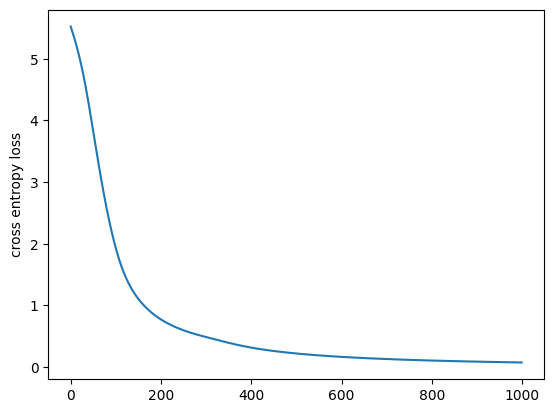

In [8]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()

#### 영화리뷰 감정분석

- RNN 을 이용해 IMDB 데이터를 가지고 텍스트 감정분석

##### 토큰화
- 토큰화는 주어진 텍스트를 토큰 단위로 나누는 작업
- 토큰화를 진행할 때 문자, 단어, 형태소와 같은 기준으로 나눌 수가 있고 spaCy, NLTK, mecab 등을 사용

##### 토큰화 라이브러리 설치
1. nltk

In [15]:
!pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 8.8 MB/s eta 0:00:00


2. konlpy, kss - 한국어 토큰화

In [24]:
!pip install konlpy

In [17]:
!pip install kss

     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 1.1/1.1 MB 27.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/26.4 MB ? eta -:--:--
     ----------------- --------------------- 11.8/26.4 MB 56.8 MB/s eta 0:00:01
     -------------------------------- ------ 22.3/26.4 MB 54.2 MB/s eta 0:00:01
     --------------------------------------- 26.4/26.4 MB 49.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status

  Using cached kss-6.0.4.tar.gz (1.1 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached emoji-1.2.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached pecab-1.0.8.tar.gz (26.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached jamo-0.4.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached hangul_jamo-1.0.1-py3-none-any.whl.metadata (899 bytes)
  Using cached tossi-0.3.1.tar.gz (11 kB)
  Installing build 

3. Mecab 
    - Mecab은 윈도우 공식 지원안함
    - C:\mecab 생성 (경로가 다를경우 설정 변경필요)
    - https://github.com/Pusnow/mecab-ko-msvc/releases 에 mecab-ko-windows-x64.zip 다운로드 압축을 위의 경로에서 해제
    - https://github.com/Pusnow/mecab-ko-dic-msvc/releases 에서 mecab-ko-dic-msvc.zip 다운로드 압축 해제

In [22]:
# !pip install "mecab_python-0.996_ko_0.9.2_msvc-cp311-cp311-win_amd64.whl"
!pip install mecab_python

##### Mecab 사용 확인

In [9]:
from konlpy.tag import Mecab

In [10]:
mecab = Mecab(dicpath='C:/mecab/mecab-ko-dic/')
mecab.morphs('아버지가방에들어가신다')

['아버지', '가', '방', '에', '들어가', '신다']

4. spaCy

In [32]:
!pip install spacy

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.2 MB 14.7 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.2 MB 37.7 MB/s eta 0:00:01
   ---------------------------------------- 12.2/12.2 MB 34.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 27.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 39.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   ----- ---------------------------------- 2.1/15.9 MB 16.7 MB/s eta 0:00:01
   ---------------------------------- ----- 13.9/15.9 MB 41.6 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 38.4 MB/s eta 0:00:00
   ------------------

  You can safely remove it manually.
  You can safely remove it manually.


##### 영어모델 다운로드

In [33]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 2.4 MB/s eta 0:00:06
     ------ --------------------------------- 2.1/12.8 MB 4.3 MB/s eta 0:00:03
     ---------------- ----------------------- 5.2/12.8 MB 7.8 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 14.9 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 14.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


##### 사용확인

In [11]:
import spacy

In [12]:
nlp = spacy.load('en_core_web_sm')
text = 'SpaCy is an excellent tool for NLP in Python.'

doc = nlp(text)

In [13]:
for token in doc:
    print(token.text, token.pos_)

SpaCy PROPN
is AUX
an DET
excellent ADJ
tool NOUN
for ADP
NLP PROPN
in ADP
Python PROPN
. PUNCT


### 단어사전 Vocabulary

- 단어 사전은 텍스트의 모든 단어의 집합
- A man is crossing the road를 기준

    ```python
    { '<unk>' : 0, '<pad>' : 1, 'a' : 2, 'man' : 3, 'is' : 4, 'crossing' : 5, 'the' : 6, 'road' : 7}

    <unk> : 단어 사전에 없는 단어가 존재할 때 사용
    <pad> : 문장의 크기를 맞출 때 사용
    ```

- A man is crossing the road -> [2, 3, 4, 5, 6, 7] 로 변경


### 워드 임베딩 WordEmbedding

- 단어를 표현할 때 원 핫 인코딩을 사용할 수도 있지만 원 핫 인코딩의 경우 단어 사이의 유사도를 판단할 수 없음
- 워드 임베딩과 밀집 벡터를 사용하면 이러한 문제점을 해결

### RNN Recurrent Neural Network

- 은닉상태 - 은닉층의 노드에서 활성화 함수를 통해 나온 값
- RNN은 이 값을 출력층과 다음 은닉층의 노드, 총 두 곳으로 전달

    <img src="https://wikidocs.net/images/page/22886/rnn_image2_ver3.PNG" width="600">

    [https://wikidocs.net/60690](https://wikidocs.net/60690) 발췌

#### 기초 RNN

In [14]:
import torch
import torch.nn as nn

input_size = 4 # 사용자가 임의로 정할 수 있는 입력 벡터의 차원
hidden_size = 5 # 셀의 크기

cell = nn.RNN(input_size, hidden_size)

batch_size = 10 # 미니 배치 크기. 1000개의 텍스트 데이터가 있고 batch_size가 10이라면 10개씩 끊어서 총 100번 학습을 진행
time_steps = 6 # 텍스트의 토큰 개수

# 입력 벡터 (배치크기, 토큰개수, 임베딩 벡터 차원)
inputs = torch.Tensor(batch_size, time_steps, input_size)


# outputs : 모든 시점의 은닉 상태
# _status : 마지막 시점 은닉 상태
outputs, _status = cell(inputs)
print(outputs.shape, _status.shape)

torch.Size([10, 6, 5]) torch.Size([1, 6, 5])


#### 영화리뷰 감정분석 다시 시작

##### torchtext와 맞는 버전의 cuda 명령어 완성

- 버전 다운그레이드 필수

```shell
> pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchtext==0.15.2 --index-url https://download.pytorch.org/whl/cu118
```

- pip 버전 함부로 올리지 말것!


##### 3분 파이토치의 예제도 함수 변경으로 실행불가

In [7]:
!pip install portalocker


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from konlpy.tag import Mecab # Mecab 설치했다면 Mecab 사용
from konlpy.tag import Okt # Mecab 설치가 어렵다면 Okt 사용
import pandas as pd
import torch

In [12]:
# 하이퍼 파라미터
vocab_size = 30_000  # 상위 30,000개의 단어만 포함

n_classes = 2
learning_late = 0.001
batch_size = 64
epochs = 10
hidden_dim = 256
embed_dim = 128

In [2]:
import urllib.request
import pandas as pd

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

# 데이터프레임으로 읽음
train_df = pd.read_table('ratings_train.txt')
test_df = pd.read_table('ratings_test.txt')

In [3]:
class CustomDataset(Dataset):
    def __init__(self, filename):
    	# 데이터프레임으로 읽고 빈 칸은 ''로 채운다.
        data_df = pd.read_table(filename).fillna('')
        
        # document 열을 읽어온다.
        x_data = data_df['document'].values
        self.x_data = x_data
        
        # label열을 읽어온다.
        self.y_data = data_df['label'].values

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return y, x

##### 훈련과 테스트 데이터 셋을 생성

In [4]:
train_iter = CustomDataset("ratings_train.txt")
eval_iter = CustomDataset("ratings_test.txt")

#### 토크나이저

##### Mecab 확인

In [5]:
from konlpy.tag import Mecab
tokenizer = Mecab(dicpath='C:/mecab/mecab-ko-dic/')
print(tokenizer.morphs('안녕하세요 좋은 아침입니다'))

['안녕', '하', '세요', '좋', '은', '아침', '입니다']


##### Okt 확인

- Okt는 JAVA_HOME 필요!

In [6]:
from konlpy.tag import Okt
tokenizer = Okt()
print(tokenizer.morphs('안녕하세요 좋은 아침입니다'))

JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.

##### 토큰화 시 yeild 필수

In [7]:
def yield_tokens(data_iter):
    for _, x in data_iter:
        yield tokenizer.morphs(x)

In [8]:
# 단어 사전 생성
# unknown 토큰과 padding 토큰 추가
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])

# 단어 사전이 없으면 <unk> 토큰 사용
vocab.set_default_index(vocab["<unk>"])

In [9]:
# 텍스트 처리 파이프라인
text_pipeline = lambda x : vocab(tokenizer.morphs(x))
label_pipeline = lambda x : int(x)

def collate_batch(batch):
    label_list, text_list = [], []
    for (label, text) in batch:
        # label 파이프라인
        label_list.append(label_pipeline(label))

        # 토큰화 진행 후 정수 인덱스로 변경
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)

    # label list 텐서로 변경
    label_list = torch.tensor(label_list, dtype=torch.int64)

    # 문장의 길이가 전부 다르기 때문에 padding을 추가하여 전부 동일하게 맞춤
    text_list = pad_sequence(text_list, batch_first=True, padding_value=1)
    return label_list, text_list

In [13]:
# 데이터 로더
train_dataloader = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)

In [14]:
# RNN 모델
class Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_classes, batch_first=True):
        super(Model, self).__init__()
        # 임베딩
        self.embedding_layer = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=1
        )
        # RNN
        self.rnn_layer = nn.RNN(
            embed_dim,
            hidden_dim, # 입력 차원, 은닉 상태의 크기 정의
            batch_first=batch_first
            )
        # 마지막은 클래스의 개수로 변환
        # 그렇게 해야 클래스 분류를 진행할 수 있음\
        self.linear = nn.Linear(hidden_dim, n_classes) # 출력은 원-핫 벡터의 크기를 가져야함. 또는 단어 집합의 크기만큼 가져야함.

    def forward(self, x):
        # (배치 크기, 시퀀스 길이) => (배치 크기, 시퀀스 길이, 임베딩 차원)
        x = self.embedding_layer(x)
        # (배치 크기, 시퀀스 길이, 임베딩 차원) => output (배치 크기, 시퀀스 길이, 은닉층 크기), hidden (1, 배치 크기, 은닉층 크기)
        output, hidden = self.rnn_layer(x)

        # (배치 크기, 시퀀스 길이, 은닉 상태 크기) => (배치 크기, 은닉 상태 크기)
        output = output[:, -1, :]

        # (배치 크기, 은닉 상태 크기) => (배치 크기, 클래스 크기)
        output = self.linear(output)
        return output

In [16]:
# CUDA 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda')

In [24]:
def train(model, optimizer, train_iter):
    model.train()
    for i, (y, x) in enumerate(train_iter):
        y, x = y.to('cpu'), x.to('cpu'),
        optimizer.zero_grad()
        hypothesis = model(x)
        loss = F.cross_entropy(hypothesis, y)
        loss.backward()
        optimizer.step()
        if (i+1)%100==0:
            print(f'{i+1}번 반복. loss : {loss.sum().item()}')
            
def evaluate(model, val_iter):
    model.eval()
    corrects, total_loss = 0, 0
    for y, x in val_iter:
        y, x = y.to('cpu'), x.to('cpu'),
        hypothesis = model(x)
        loss = F.cross_entropy(hypothesis, y)
        total_loss += loss.item()
        corrects += (hypothesis.max(dim=1)[1]==y).sum()
    size = len(val_iter)
    avg_loss = total_loss/size
    acc = (corrects/(size*batch_size))*100
    return avg_loss, acc

In [25]:
# 모델 생성
model = Model(vocab_size, embed_dim, hidden_dim, n_classes, batch_first=True).to(device)

# 옵티마이저 생성
optimizer = torch.optim.Adam(model.parameters(), lr=learning_late)

# 데이터 로더 생성
train_dataloader = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
eval_dataloader = DataLoader(eval_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
# 학습 시작
for i in range(1, epochs+1):

    train(model, optimizer, train_dataloader)
    # 평가 시작
    avg_loss, acc = evaluate(model, eval_dataloader)
    print(f'[{i}/{epochs}] 평균 loss : {avg_loss} 정학도 : {acc}')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
